# PCB AC analysis

This example shows how to use PyAEDT to create a design in
Q3D Extractor and run a simulation starting from an EDB project.

Keywords: **Q3D**, **PCB**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

import ansys.aedt.core
from ansys.aedt.core.examples.downloads import download_file
import pyedb

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Set up project files and path

Download needed project file and set up temporary project directory.

In [4]:
project_dir = os.path.join(temp_folder.name, "edb")
aedb_project = download_file(
    source="edb/ANSYS-HSD_V1.aedb", local_path=project_dir
)

project_name = os.path.join(temp_folder.name, "HSD")
output_edb = os.path.join(project_dir, project_name + ".aedb")
output_q3d = os.path.join(project_dir, project_name + "_q3d.aedt")

## Open EDB and create cutout

Open the EDB project and create a cutout on the selected nets
before exporting to Q3D.

In [5]:
edb = pyedb.Edb(aedb_project, edbversion=AEDT_VERSION)
cutout_points = edb.cutout(
    ["CLOCK_I2C_SCL", "CLOCK_I2C_SDA"],
    ["GND"],
    output_aedb_path=output_edb,
    use_pyaedt_extent_computing=True,
)

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 05:19:18.000699


INFO:Edb:Star initializing Edb 05:19:18.000699


PyEDB INFO: Edb version 2025.2


INFO:Edb:Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


INFO:Edb:Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.61.0


INFO:Edb:legacy v0.61.0


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


INFO:Edb:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


INFO:Edb:Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


INFO:Edb:Cell main Opened


PyEDB INFO: Builder was initialized.


INFO:Edb:Builder was initialized.


PyEDB INFO: open_edb completed in 9.0746 seconds.


INFO:Edb:open_edb completed in 9.0746 seconds.


PyEDB INFO: EDB initialization completed in 9.1383 seconds.


INFO:Edb:EDB initialization completed in 9.1383 seconds.


PyEDB INFO: -----------------------------------------


INFO:Edb:-----------------------------------------


PyEDB INFO: Trying cutout with (0.002)*(1000.0)mm expansion size


INFO:Edb:Trying cutout with (0.002)*(1000.0)mm expansion size


PyEDB INFO: -----------------------------------------


INFO:Edb:-----------------------------------------


PyEDB INFO: EDB file save completed in 0.1433 seconds.


INFO:Edb:EDB file save completed in 0.1433 seconds.


PyEDB INFO: Cutout Multithread started.


INFO:Edb:Cutout Multithread started.


PyEDB INFO: Net clean up Elapsed time: 0m 1sec


INFO:Edb:Net clean up Elapsed time: 0m 1sec


PyEDB INFO: Extent Creation Elapsed time: 0m 0sec


INFO:Edb:Extent Creation Elapsed time: 0m 0sec


PyEDB INFO: 1956 Padstack Instances deleted. Elapsed time: 0m 1sec


INFO:Edb:1956 Padstack Instances deleted. Elapsed time: 0m 1sec


PyEDB INFO: 420 Primitives deleted. Elapsed time: 0m 3sec


INFO:Edb:420 Primitives deleted. Elapsed time: 0m 3sec


PyEDB INFO: 994 components deleted


INFO:Edb:994 components deleted


PyEDB INFO: Save Edb file completed in 0.0483 seconds.


INFO:Edb:Save Edb file completed in 0.0483 seconds.


PyEDB INFO: Cutout completed. Elapsed time: 0m 5sec


INFO:Edb:Cutout completed. Elapsed time: 0m 5sec


PyEDB INFO: EDB file save completed in 0.0477 seconds.


INFO:Edb:EDB file save completed in 0.0477 seconds.


PyEDB INFO: Cutout completed in 1 iterations with expansion size of (0.002)*(1000.0)mm Elapsed time: 0m 5sec


INFO:Edb:Cutout completed in 1 iterations with expansion size of (0.002)*(1000.0)mm Elapsed time: 0m 5sec


## Identify locations of pins

Identify $(x,y)$ pin locations on the components to define where to assign sources
and sinks for Q3D.

In [6]:
pin_u13_scl = [
    i for i in edb.components["U13"].pins.values() if i.net_name == "CLOCK_I2C_SCL"
]
pin_u1_scl = [
    i for i in edb.components["U1"].pins.values() if i.net_name == "CLOCK_I2C_SCL"
]
pin_u13_sda = [
    i for i in edb.components["U13"].pins.values() if i.net_name == "CLOCK_I2C_SDA"
]
pin_u1_sda = [
    i for i in edb.components["U1"].pins.values() if i.net_name == "CLOCK_I2C_SDA"
]

## Append Z elevation positions

> **Note:** The factor 1000 converts from meters to millimeters.

In [7]:
location_u13_scl = [i * 1000 for i in pin_u13_scl[0].position]
location_u13_scl.append(edb.components["U13"].upper_elevation * 1000)

location_u1_scl = [i * 1000 for i in pin_u1_scl[0].position]
location_u1_scl.append(edb.components["U1"].upper_elevation * 1000)

location_u13_sda = [i * 1000 for i in pin_u13_sda[0].position]
location_u13_sda.append(edb.components["U13"].upper_elevation * 1000)

location_u1_sda = [i * 1000 for i in pin_u1_sda[0].position]
location_u1_sda.append(edb.components["U1"].upper_elevation * 1000)

## Save and close EDB

Save and close EDB. Then, open the EDB project in HFSS 3D Layout to generate the 3D model.

In [8]:
edb.save_edb()
edb.close_edb()

h3d = ansys.aedt.core.Hfss3dLayout(
    output_edb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyEDB INFO: Save Edb file completed in 0.0479 seconds.


INFO:Edb:Save Edb file completed in 0.0479 seconds.


PyEDB INFO: Close Edb file completed in 0.0791 seconds.


INFO:Edb:Close Edb file completed in 0.0791 seconds.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


INFO:Global:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.22.dev0.


INFO:Global:PyAEDT version 0.22.dev0.


PyAEDT INFO: Initializing new Desktop session.


INFO:Global:Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


INFO:Global:Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_3dc2fa1f-4d97-4c6d-b19b-a7cdbd4c224b.log is enabled.


INFO:Global:Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_3dc2fa1f-4d97-4c6d-b19b-a7cdbd4c224b.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


INFO:Global:Log on AEDT is disabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


INFO:Global:Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


INFO:Global:Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 56370.


INFO:Global:New AEDT session is starting on gRPC port 56370.


PyAEDT INFO: Electronics Desktop started on gRPC port: 56370 after 10.70796251296997 seconds.


INFO:Global:Electronics Desktop started on gRPC port: 56370 after 10.70796251296997 seconds.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


INFO:Global:AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Ansoft.ElectronicsDesktop.2025.2 version started with process ID 7756.


INFO:Global:Ansoft.ElectronicsDesktop.2025.2 version started with process ID 7756.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD.aedb has been imported to project HSD


INFO:Global:EDB folder C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD.aedb has been imported to project HSD


PyAEDT INFO: Active Design set to 0;main


INFO:Global:Active Design set to 0;main


PyAEDT INFO: Active Design set to 0;main


INFO:Global:Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


INFO:Global:Aedt Objects correctly read


## Set up the Q3D Project

Use HFSS 3D Layout to export the model to Q3D Extractor. The named parameter
``keep_net_name=True`` ensures that net names are retained when the model is exported from HFSS 3D Layout.

In [9]:
setup = h3d.create_setup()
setup.export_to_q3d(output_q3d, keep_net_name=True)
h3d.close_project()
time.sleep(3)

PyAEDT INFO: Project: HSD, Design: main, [info]  Translation Info: Export complete (00:00:03). (05:20:16 AM  Oct 30, 2025)


INFO:Global:Project: HSD, Design: main, [info]  Translation Info: Export complete (00:00:03). (05:20:16 AM  Oct 30, 2025)


PyAEDT INFO: Project: HSD, Design: main, [info]  File written to C:/Users/ansys/AppData/Local/Temp/tmp7fbvgp34.ansys/HSD_q3d.aedt. (05:20:16 AM  Oct 30, 2025)


INFO:Global:Project: HSD, Design: main, [info]  File written to C:/Users/ansys/AppData/Local/Temp/tmp7fbvgp34.ansys/HSD_q3d.aedt. (05:20:16 AM  Oct 30, 2025)


PyAEDT INFO: Loading Modeler.


INFO:Global:Loading Modeler.


PyAEDT INFO: Modeler loaded.


INFO:Global:Modeler loaded.


PyAEDT INFO: EDB loaded.


INFO:Global:EDB loaded.


PyAEDT INFO: Layers loaded.


INFO:Global:Layers loaded.


PyAEDT INFO: Primitives loaded.


INFO:Global:Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Modeler class has been initialized! Elapsed time: 0m 0sec


PyEDB INFO: Star initializing Edb 05:20:18.631480


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)
INFO:Edb:Star initializing Edb 05:20:18.631480


PyEDB INFO: Edb version 2025.2


INFO:Edb:Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


INFO:Edb:Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.61.0


INFO:Edb:legacy v0.61.0


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


INFO:Edb:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database HSD.aedb Opened in 2025.2


INFO:Edb:Database HSD.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


INFO:Edb:Cell main Opened


PyEDB INFO: Builder was initialized.


INFO:Edb:Builder was initialized.


PyEDB INFO: open_edb completed in 0.0912 seconds.


INFO:Edb:open_edb completed in 0.0912 seconds.


PyEDB INFO: EDB initialization completed in 0.1107 seconds.


INFO:Edb:EDB initialization completed in 0.1107 seconds.


PyAEDT INFO: Processing net GND...


INFO:Global:Processing net GND...


PyAEDT INFO: Processing net CLOCK_I2C_SDA...


INFO:Global:Processing net CLOCK_I2C_SDA...


PyAEDT INFO: Processing net CLOCK_I2C_SCL...


INFO:Global:Processing net CLOCK_I2C_SCL...


PyAEDT INFO: Net processing completed.


INFO:Global:Net processing completed.


PyAEDT INFO: Processing vias...


INFO:Global:Processing vias...


PyAEDT INFO: Vias processing completed.


INFO:Global:Vias processing completed.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


INFO:Global:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD_q3d.aedt.


INFO:Global:Parsing C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD_q3d.aedt.


PyAEDT INFO: PyAEDT version 0.22.dev0.


INFO:Global:PyAEDT version 0.22.dev0.


PyAEDT INFO: Returning found Desktop session with PID 7756!


INFO:Global:Returning found Desktop session with PID 7756!


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD_q3d.aedt correctly loaded. Elapsed time: 0m 0sec


INFO:Global:File C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD_q3d.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: Project HSD_q3d has been opened.


INFO:Global:Project HSD_q3d has been opened.


PyAEDT INFO: Active Design set to Q3DDesign1


INFO:Global:Active Design set to Q3DDesign1


PyAEDT INFO: Active Design set to Q3DDesign1


INFO:Global:Active Design set to Q3DDesign1


PyAEDT INFO: Aedt Objects correctly read


INFO:Global:Aedt Objects correctly read


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Renaming primitives for net GND...


INFO:Global:Renaming primitives for net GND...


PyAEDT INFO: Parsing design objects. This operation can take time


INFO:Global:Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


INFO:Global:Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


INFO:Global:Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


INFO:Global:3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


INFO:Global:Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


INFO:Global:Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


INFO:Global:Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


INFO:Global:3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Union of 2 objects has been executed.


INFO:Global:Union of 2 objects has been executed.


PyAEDT INFO: Renaming primitives for net CLOCK_I2C_SDA...


INFO:Global:Renaming primitives for net CLOCK_I2C_SDA...


PyAEDT INFO: Parsing design objects. This operation can take time


INFO:Global:Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


INFO:Global:Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


INFO:Global:Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


INFO:Global:3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Union of 5 objects has been executed.


INFO:Global:Union of 5 objects has been executed.


PyAEDT INFO: Renaming primitives for net CLOCK_I2C_SCL...


INFO:Global:Renaming primitives for net CLOCK_I2C_SCL...


PyAEDT INFO: Parsing design objects. This operation can take time


INFO:Global:Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


INFO:Global:Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


INFO:Global:Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


INFO:Global:3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Union of 5 objects has been executed.


INFO:Global:Union of 5 objects has been executed.


PyAEDT INFO: No new nets identified


INFO:Global:No new nets identified


PyAEDT INFO: Closing the AEDT Project HSD_q3d


INFO:Global:Closing the AEDT Project HSD_q3d


PyAEDT INFO: Project HSD_q3d closed correctly


INFO:Global:Project HSD_q3d closed correctly


PyEDB INFO: Close Edb file completed in 0.0161 seconds.


INFO:Edb:Close Edb file completed in 0.0161 seconds.


PyAEDT INFO: Closing the AEDT Project HSD


INFO:Global:Closing the AEDT Project HSD


PyAEDT INFO: Project HSD closed correctly


INFO:Global:Project HSD closed correctly


Open the newly created Q3D project and display the layout.

In [10]:
q3d = ansys.aedt.core.Q3d(output_q3d, version=AEDT_VERSION)
q3d.plot(
    show=False,
    assignment=["CLOCK_I2C_SCL", "CLOCK_I2C_SDA"],
    output_file=os.path.join(temp_folder.name, "Q3D.jpg"),
    plot_air_objects=False,
)

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD_q3d.aedt.


INFO:Global:Parsing C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD_q3d.aedt.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


INFO:Global:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.22.dev0.


INFO:Global:PyAEDT version 0.22.dev0.


PyAEDT INFO: Returning found Desktop session with PID 7756!


INFO:Global:Returning found Desktop session with PID 7756!


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD_q3d.aedt correctly loaded. Elapsed time: 0m 0sec


INFO:Global:File C:\Users\ansys\AppData\Local\Temp\tmp7fbvgp34.ansys\HSD_q3d.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: Project HSD_q3d has been opened.


INFO:Global:Project HSD_q3d has been opened.


PyAEDT INFO: Active Design set to Q3DDesign1


INFO:Global:Active Design set to Q3DDesign1


PyAEDT INFO: Active Design set to Q3DDesign1


INFO:Global:Active Design set to Q3DDesign1


PyAEDT INFO: Aedt Objects correctly read


INFO:Global:Aedt Objects correctly read


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


INFO:Global:PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Modeler class has been initialized! Elapsed time: 0m 0sec


INFO:trame_server.utils.namespace:Translator(prefix=None)


INFO:wslink.backends.aiohttp:awaiting runner setup


INFO:wslink.backends.aiohttp:awaiting site startup


INFO:wslink.backends.aiohttp:Print WSLINK_READY_MSG


INFO:wslink.backends.aiohttp:Schedule auto shutdown with timout 0


INFO:wslink.backends.aiohttp:awaiting running future


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

Use the previously calculated positions to identify faces and
assign sources and sinks on nets.

In [11]:
f1 = q3d.modeler.get_faceid_from_position(location_u13_scl, assignment="CLOCK_I2C_SCL")
q3d.source(f1, net_name="CLOCK_I2C_SCL")
f1 = q3d.modeler.get_faceid_from_position(location_u13_sda, assignment="CLOCK_I2C_SDA")
q3d.source(f1, net_name="CLOCK_I2C_SDA")
f1 = q3d.modeler.get_faceid_from_position(location_u1_scl, assignment="CLOCK_I2C_SCL")
q3d.sink(f1, net_name="CLOCK_I2C_SCL")
f1 = q3d.modeler.get_faceid_from_position(location_u1_sda, assignment="CLOCK_I2C_SDA")
q3d.sink(f1, net_name="CLOCK_I2C_SDA")

PyAEDT INFO: Parsing design objects. This operation can take time


INFO:Global:Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


INFO:Global:Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


INFO:Global:Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


INFO:Global:3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: Boundary Source Source_Y2Q3K0 has been created.


INFO:Global:Boundary Source Source_Y2Q3K0 has been created.


PyAEDT INFO: Boundary Source Source_ASE3G0 has been created.


INFO:Global:Boundary Source Source_ASE3G0 has been created.


PyAEDT INFO: Boundary Sink Sink_VH3WRO has been created.


INFO:Global:Boundary Sink Sink_VH3WRO has been created.


PyAEDT INFO: Boundary Sink Sink_4E5II4 has been created.


INFO:Global:Boundary Sink Sink_4E5II4 has been created.


Define the solution setup and the frequency sweep ranging from DC to 2GHz.

In [12]:
setup = q3d.create_setup()
setup.dc_enabled = True
setup.capacitance_enabled = False
sweep = setup.add_sweep()
sweep.add_subrange(
    "LinearStep", 0, end=2, count=0.05, unit="GHz", save_single_fields=False, clear=True
)
setup.analyze(cores=NUM_CORES)

PyAEDT INFO: Project HSD_q3d Saved correctly


INFO:Global:Project HSD_q3d Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


INFO:Global:Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


PyAEDT INFO: Solving design setup MySetupAuto


INFO:Global:Solving design setup MySetupAuto


PyAEDT INFO: Design setup MySetupAuto solved correctly in 0.0h 3.0m 9.0s


INFO:Global:Design setup MySetupAuto solved correctly in 0.0h 3.0m 9.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


INFO:Global:Key Desktop/ActiveDSOConfigurations/Q3D Extractor correctly changed.


## Solve

Compute AC inductance and resistance.

In [13]:
traces_acl = q3d.post.available_report_quantities(quantities_category="ACL Matrix")
solution = q3d.post.get_solution_data(traces_acl)

PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.


Time to initialize solution data:0.01213216781616211
Time to initialize solution data:0.020538330078125


## Postprocess

Plot AC inductance and resistance.

PyAEDT WARNING: No report category provided. Automatically identified Matrix


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.01572442054748535


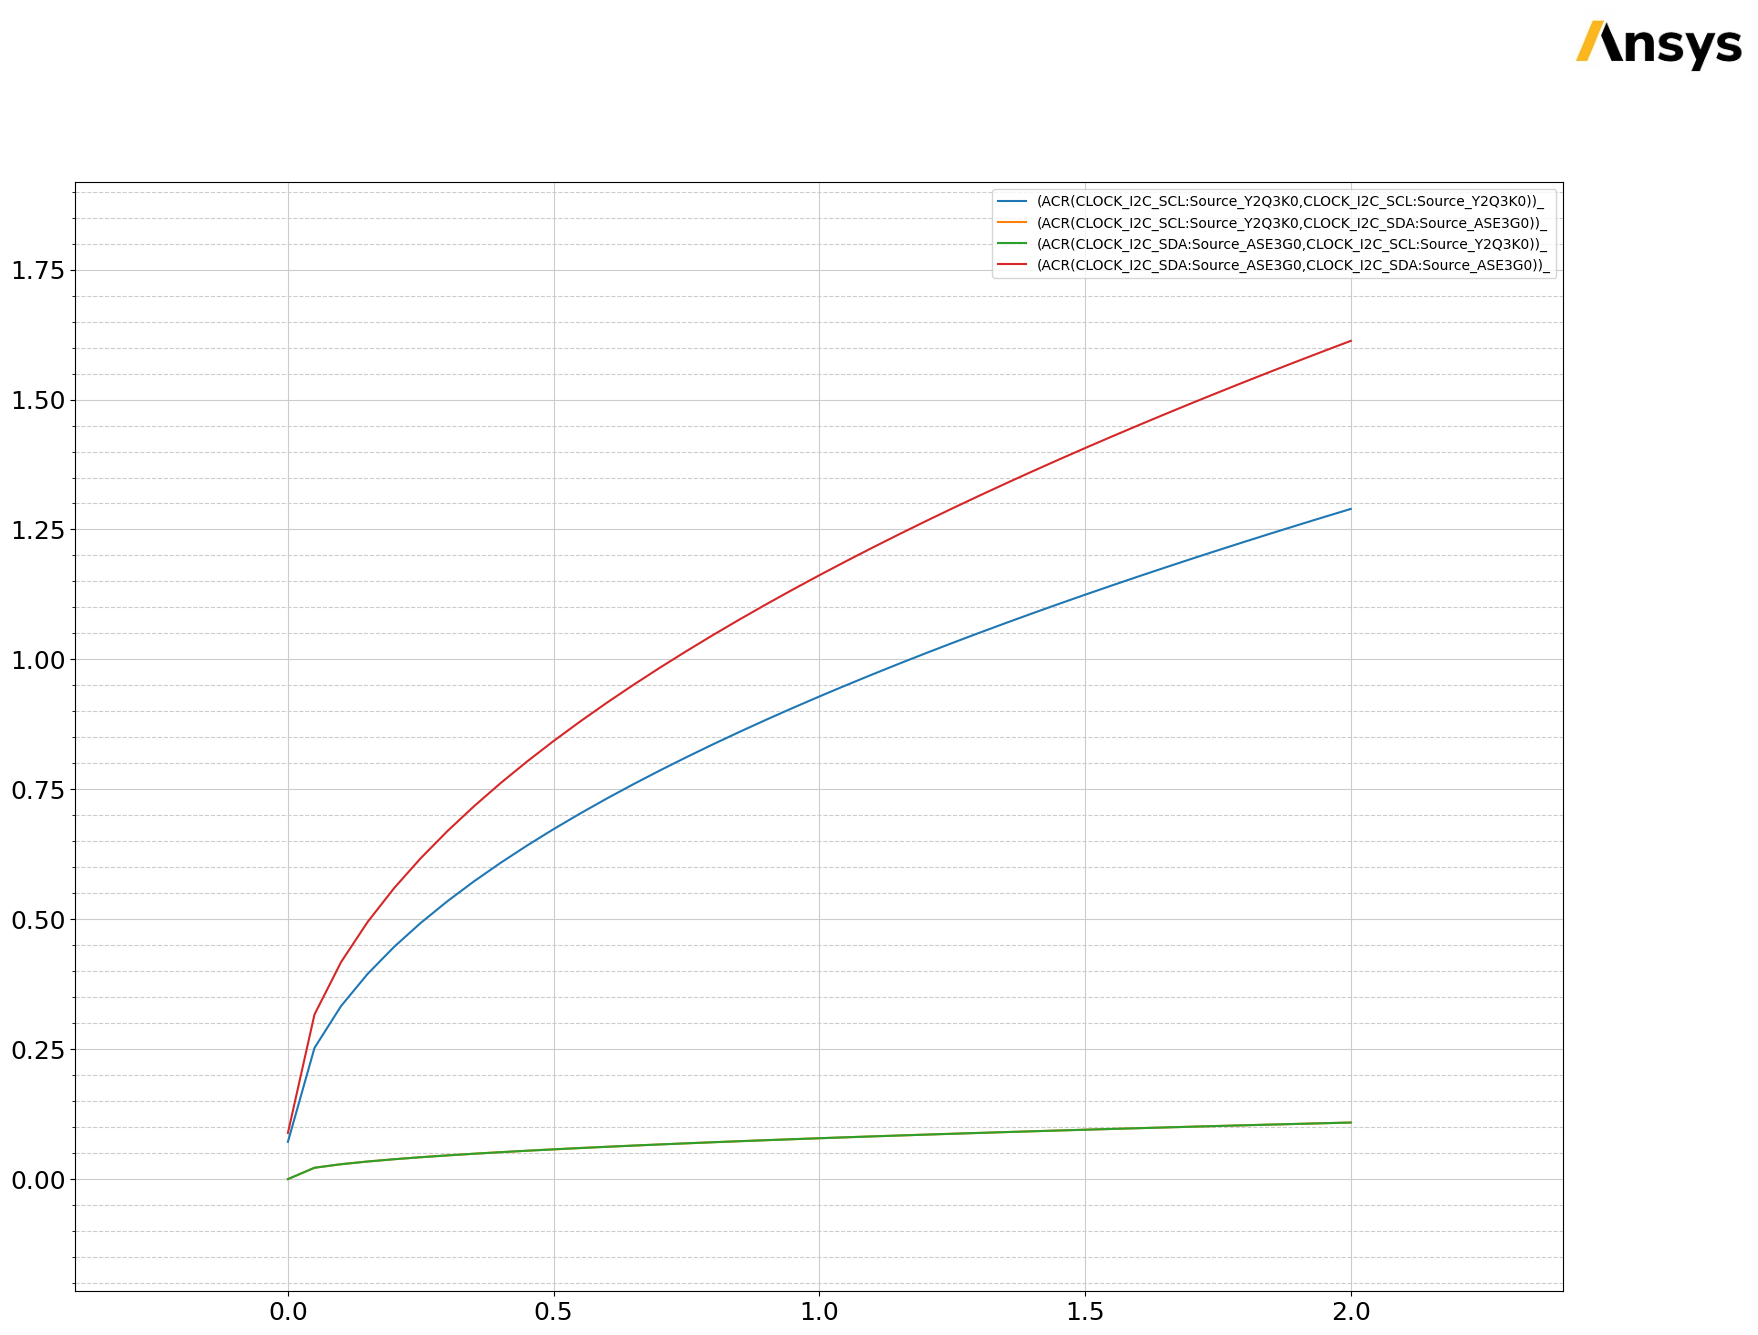

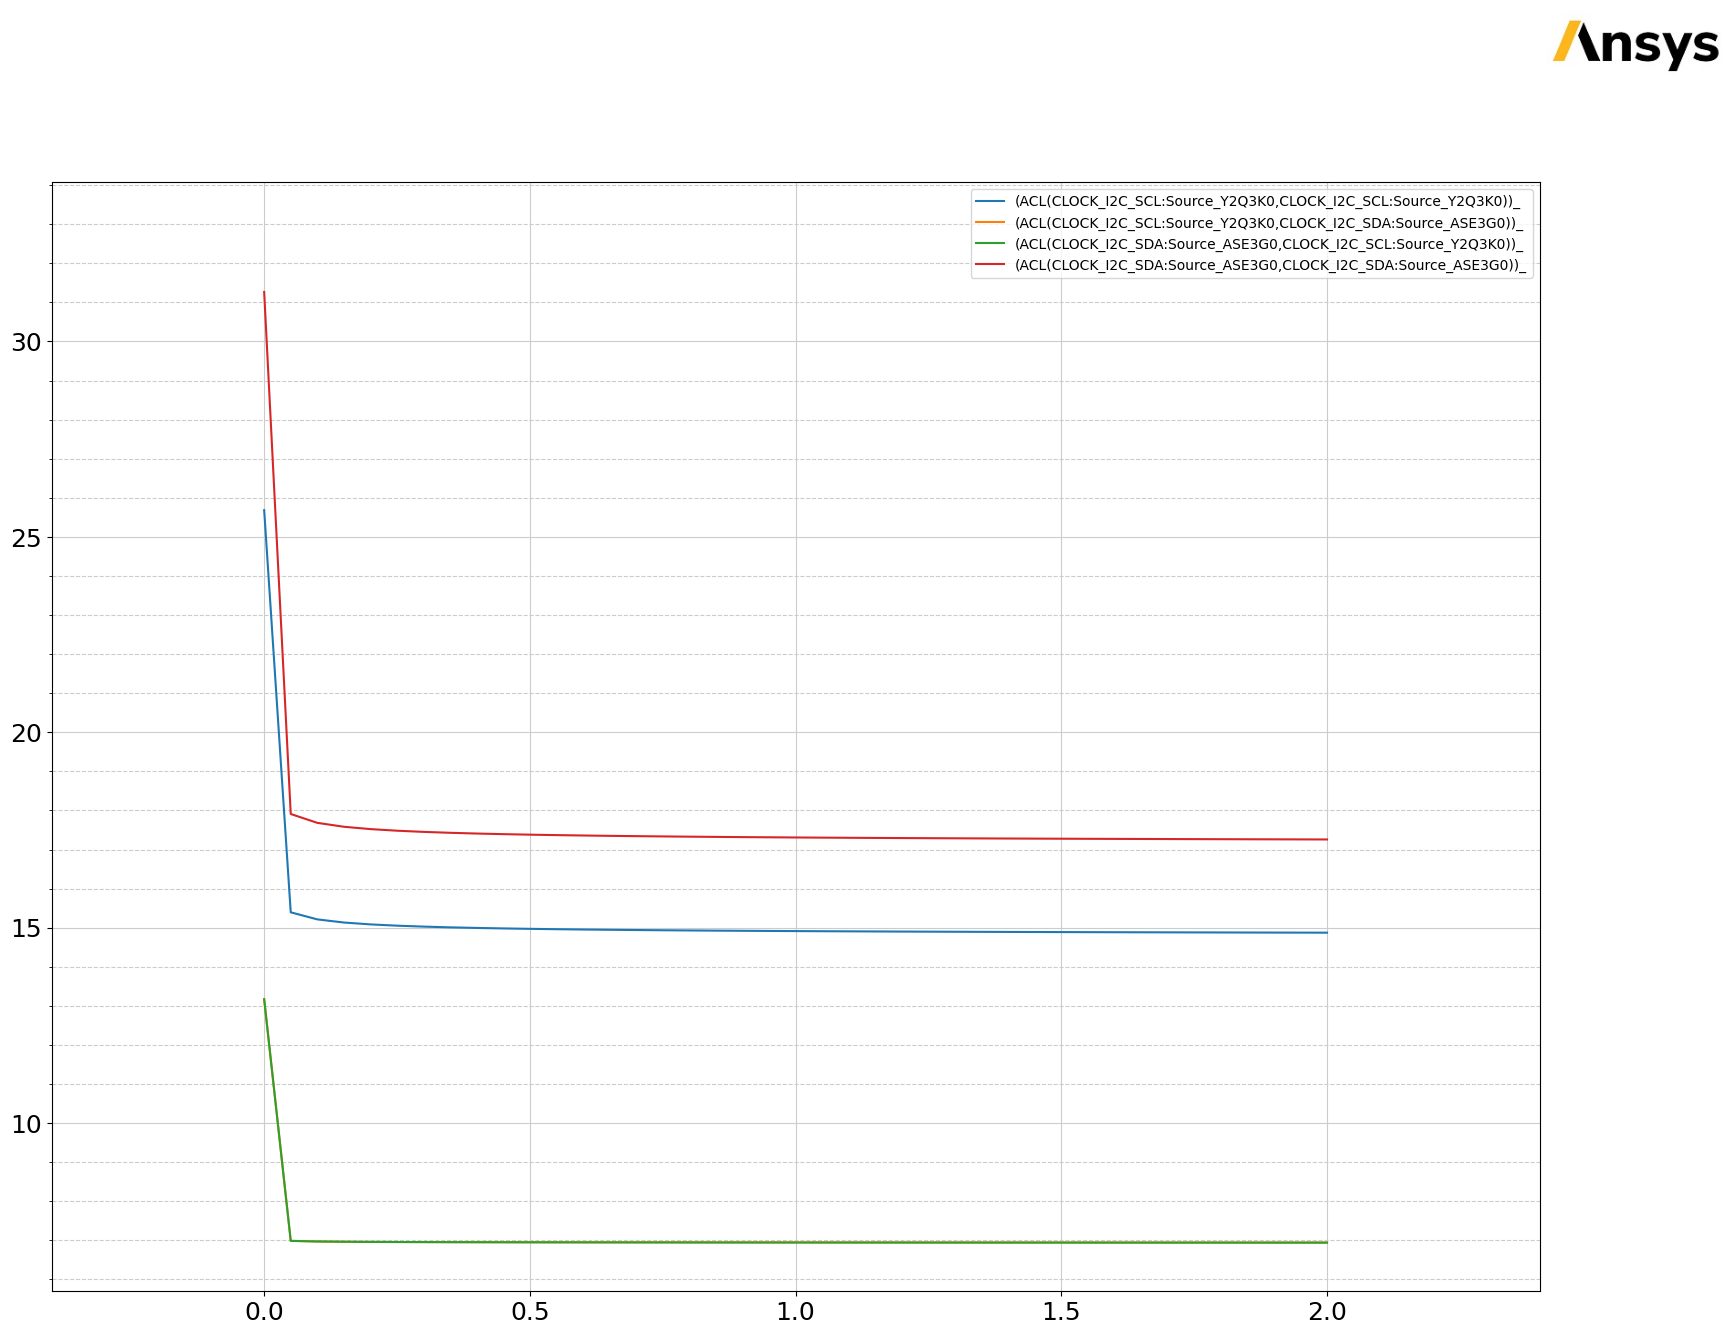

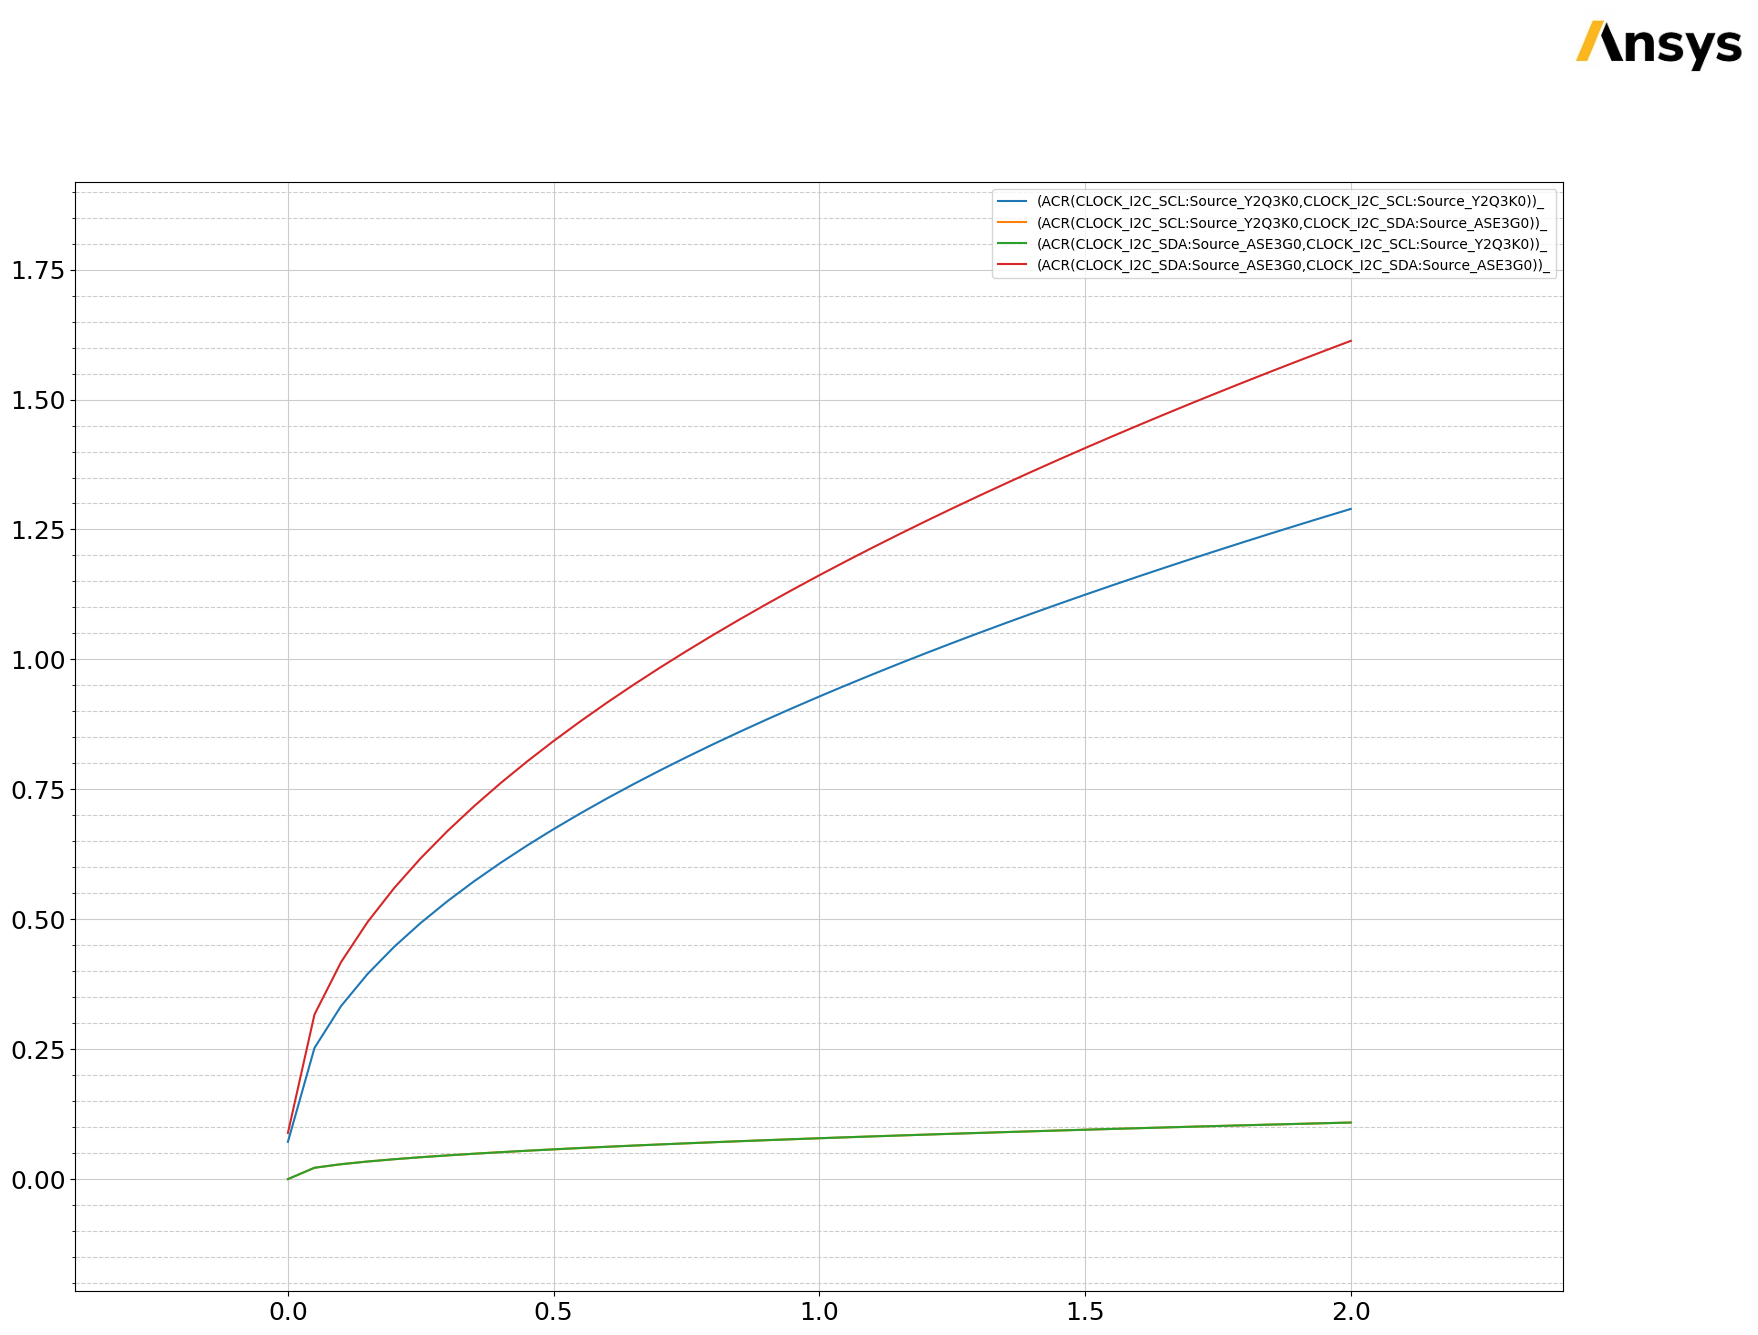

In [14]:
solution.plot()
traces_acr = q3d.post.available_report_quantities(quantities_category="ACR Matrix")
solution2 = q3d.post.get_solution_data(traces_acr)
solution2.plot()

## Release AEDT

In [15]:
q3d.save_project()
q3d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project HSD_q3d Saved correctly


INFO:Global:Project HSD_q3d Saved correctly


PyAEDT INFO: Desktop has been released and closed.


INFO:Global:Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [16]:
temp_folder.cleanup()